### Multi-Modal LLM using Google’s Gemini model for image understanding and build Retrieval Augmented Generation with LlamaIndex

In [1]:
!pip install llama-index 'google-generativeai>=0.3.0' matplotlib qdrant_client

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.7/15.7 MB 30.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.7/203.7 kB 23.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.0/143.0 kB 17.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.9/75.9 kB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 225.4/225.4 kB 24.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 42.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 44.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.8/143.8 kB 16.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 26.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.9/76.9 kB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━

In [2]:
import os
# add your GOOGLE API key here
GOOGLE_API_KEY = ""
os.environ["GOOGLE_API_KEY"] = GOOGLE_API_KEY

In [3]:
import google.generativeai as genai

genai.configure(
    api_key=GOOGLE_API_KEY,
    client_options={"api_endpoint": "generativelanguage.googleapis.com"},
)


In [4]:
#no of models offered by gemini as present
for m in genai.list_models():
    if "generateContent" in m.supported_generation_methods:
        print(m.name)

models/gemini-pro
models/gemini-pro-vision


In [5]:
from pathlib import Path

input_image_path = Path("restaurants_data")
if not input_image_path.exists():
    Path.mkdir(input_image_path)

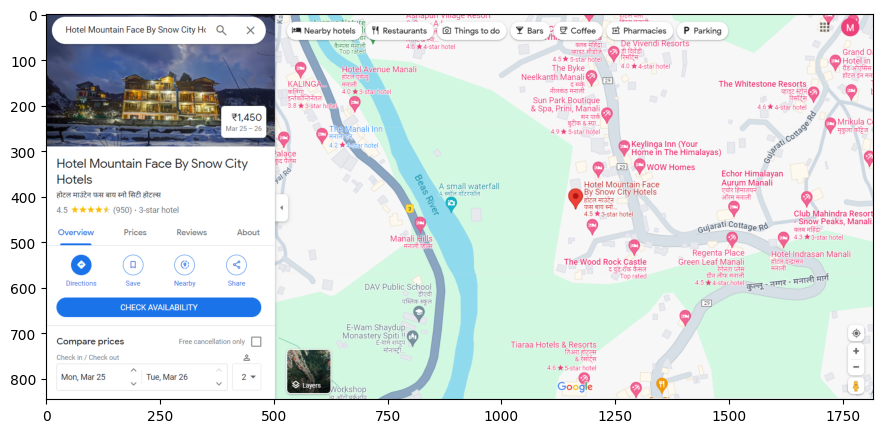

In [15]:
from pydantic import BaseModel
from PIL import Image
import matplotlib.pyplot as plt


class GoogleRestaurant(BaseModel):
    """Data model for a Google Restaurant."""

    restaurant: str
    food: str
    location: str
    category: str
    hours: str
    price: str
    rating: float
    review: str
    description: str
    nearby_tourist_places: str


google_image_url = "./restaurants_data/Res-2.png"
image = Image.open(google_image_url).convert("RGB")

plt.figure(figsize=(16, 5))
plt.imshow(image)

In [16]:
from llama_index.multi_modal_llms import GeminiMultiModal
from llama_index.program import MultiModalLLMCompletionProgram
from llama_index.output_parsers import PydanticOutputParser

prompt_template_str = """\
    Observe the image and summarize what is present in the image \
    and return the answer with json format \
"""


def pydantic_gemini(
    model_name, output_class, image_documents, prompt_template_str
):
    gemini_llm = GeminiMultiModal(
        api_key=GOOGLE_API_KEY, model_name=model_name
    )

    llm_program = MultiModalLLMCompletionProgram.from_defaults(
        output_parser=PydanticOutputParser(output_class),
        image_documents=image_documents,
        prompt_template_str=prompt_template_str,
        multi_modal_llm=gemini_llm,
        verbose=True,
    )

    response = llm_program()
    return response


In [18]:
from llama_index import SimpleDirectoryReader

google_image_documents = SimpleDirectoryReader(
    "./restaurants_data"
).load_data()

results = []
for img_doc in google_image_documents:
    pydantic_response = pydantic_gemini(
        "models/gemini-pro-vision",
        GoogleRestaurant,
        [img_doc],
        prompt_template_str,
    )
    results.append(pydantic_response)


In [19]:
results

[GoogleRestaurant(restaurant='Hotel Mountain Face By Snow City Hotels', food='Indian, Chinese, Continental', location='Near Mall Road, Manali', category='Hotel', hours='24 hours', price='₹1,450', rating=4.5, review='4.5 out of 5', description='Hotel Mountain Face By Snow City Hotels is a 3-star hotel located in Manali, India. The hotel offers a variety of amenities, including a restaurant, bar, and fitness center. The rooms are well-appointed and offer stunning views of the surrounding mountains.', nearby_tourist_places='Hadimba Temple, Manu Temple, Solang Valley'),
 GoogleRestaurant(restaurant='Hotel Solitaire Manali Near Mall Road', food='North Indian, Chinese, Continental', location='Manali, India', category='Hotel', hours='Open 24 hours', price='₹1,274', rating=4.3, review='1,409', description='Hotel Solitaire, Manali is a 3 star hotel located in the heart of Manali, just a few steps away from the famous Mall Road. The hotel offers a range of accommodation options, including deluxe

In [20]:
from llama_index.schema import TextNode

nodes = []
for res in results:
    text_node = TextNode()
    metadata = {}
    for r in res:
        # set description as text of TextNode
        if r[0] == "description":
            text_node.text = r[1]
        else:
            metadata[r[0]] = r[1]
    text_node.metadata = metadata
    nodes.append(text_node)


In [21]:
nodes

[TextNode(id_='afc765d4-c0e5-40b9-89dc-d0b381b4afa1', embedding=None, metadata={'restaurant': 'Hotel Mountain Face By Snow City Hotels', 'food': 'Indian, Chinese, Continental', 'location': 'Near Mall Road, Manali', 'category': 'Hotel', 'hours': '24 hours', 'price': '₹1,450', 'rating': 4.5, 'review': '4.5 out of 5', 'nearby_tourist_places': 'Hadimba Temple, Manu Temple, Solang Valley'}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={}, hash='44136fa355b3678a1146ad16f7e8649e94fb4fc21fe77e8310c060f61caaff8a', text='Hotel Mountain Face By Snow City Hotels is a 3-star hotel located in Manali, India. The hotel offers a variety of amenities, including a restaurant, bar, and fitness center. The rooms are well-appointed and offer stunning views of the surrounding mountains.', start_char_idx=None, end_char_idx=None, text_template='{metadata_str}\n\n{content}', metadata_template='{key}: {value}', metadata_seperator='\n'),
 TextNode(id_='5612738e-ea1b-4640-a720-6a55

In [23]:
from llama_index import VectorStoreIndex, StorageContext, ServiceContext
from llama_index.embeddings import GeminiEmbedding
from llama_index.llms import Gemini
from llama_index.vector_stores import QdrantVectorStore
from llama_index import StorageContext
import qdrant_client


# Create a local Qdrant vector store
client = qdrant_client.QdrantClient(path="qdrant_gemini_2")

vector_store = QdrantVectorStore(client=client, collection_name="collection")

# Using the embedding model to Gemini
embed_model = GeminiEmbedding(
    model_name="models/embedding-001", api_key=GOOGLE_API_KEY
)
service_context = ServiceContext.from_defaults(
    llm=Gemini(api_key=GOOGLE_API_KEY), embed_model=embed_model
)
storage_context = StorageContext.from_defaults(vector_store=vector_store)

index = VectorStoreIndex(
    nodes=nodes,
    service_context=service_context,
    storage_context=storage_context,
)

In [24]:
query_engine = index.as_query_engine(
    similarity_top_k=1,
)

response = query_engine.query(
    "recommend a good cheap hotels between 500 Rs to 1000 Rs dining restaurant for me and its nearby visting places"
)
print(response)

I am sorry, but I cannot provide a recommendation for a good cheap hotel between 500 Rs to 1000 Rs dining restaurant and its nearby visiting places as the context does not contain any information about hotels or restaurants in that price range.


In [28]:
query_engine = index.as_query_engine(
    similarity_top_k=1,
)

response = query_engine.query(
    "recommend a good dining restaurant for me and its nearby visting places"
)
print(response)

Hotel Mountain Face By Snow City Hotels is a recommended dining restaurant with a rating of 4.5 out of 5. Nearby visiting places include Hadimba Temple, Manu Temple, and Solang Valley.


In [30]:
query_engine = index.as_query_engine(
    similarity_top_k=2,
)

response = query_engine.query(
    "recommend a good dining restaurant having chinese food served ?"
)
print(response)

Based on the provided context, I can recommend two restaurants that serve Chinese food:

1. Hotel Solitaire Manali Near Mall Road: This restaurant offers a range of North Indian, Chinese, and Continental dishes. It is located in the heart of Manali, just a few steps away from the famous Mall Road.

2. Hotel Mountain Face By Snow City Hotels: This restaurant serves Indian, Chinese, and Continental cuisine. It is located near Mall Road in Manali and offers stunning views of the surrounding mountains.

Both restaurants have good ratings and reviews, so you can choose the one that best suits your preferences.
